In [193]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pickle
import time
import os
tqdm.pandas()
sns.set_style("whitegrid")
%config InlineBackend.figure_formats = ['svg']

# Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error

# Ignore warning
import warnings
warnings.filterwarnings('ignore',"X does not have valid.*")
warnings.filterwarnings('ignore',".*deprecated.*")
warnings.filterwarnings('ignore',".*PyTorch not found..*")

### Utiles

In [194]:
# Le modèle prend x et donne l'ID de la classe LABEL
# Dans la dataset, on a appliqué du OneHotEncoding par défaut
# Certains algos comme GaussianNB ont besoin d'avoir
# juste l'ID comme target et non pas un vecteur OneHot
# Comme les autres algo sont compatibles, on va donc
# y_train [OneHot] -> to_label_category [Id categorie]
# Et à la prédiction
# y_pred [Id categorie] -> to_one_hot [OneHot]
# pour le comparer au y_test [OneHot] de la dataset

def to_label_category(y_set):
    return LABEL_COLUMN_LIST.get_indexer(y_set.idxmax(axis=1))

def to_one_hot(y_set):
    vect = np.zeros((len(y_set), len(LABEL_COLUMN_LIST)))
    vect[np.arange(len(y_set)), y_set] = 1
    return vect

In [195]:
def draw_confusion_matrix(model_name, y_true, y_pred, attack_name=None, fig_path=None, title_suffix="", **kwargs):
    id_label_column = [i for i in range(len(LABEL_COLUMN_LIST))]
    cf_matrix = confusion_matrix(y_pred.argmax(axis=1), y_true.values.argmax(axis=1), labels=id_label_column)
    cf_matrix_df = pd.DataFrame(cf_matrix, 
        index=LABEL_COLUMN_LIST, 
        columns=LABEL_COLUMN_LIST)
    norm_cf_matrix_df = cf_matrix_df/cf_matrix_df.sum(axis=0)

    plt.figure(figsize=(10,10))
    g = sns.heatmap(norm_cf_matrix_df,
                annot=True,
                fmt='.3f',
                cmap='rocket_r')
    g.set_xlabel("Vraie classe")
    g.set_ylabel("Classe prédite par le modèle")
    title = f"Matrice de confusion {title_suffix}(en proportion d'exemples)\n Modèle : {model_name} / Dataset : {LEVEL}"
    if attack_name is not None:
        title += f" / Attaque : {attack_name}"
    g.set_title(title)
    if fig_path is not None:
        plt.savefig(f"graph/cf-matrix_{fig_path}.svg", bbox_inches='tight')
    plt.show()

def compute_score(y_true, y_pred, with_auroc=True, **kwargs):
    score_dict = dict()
    score_dict["accuracy_score"] = accuracy_score(y_true, y_pred)
    score_dict["f1_score"] = f1_score(y_true, y_pred, average="micro")
    if with_auroc:
        # Si il y a peu d'exemples
        # AUROC peut être difficile voire impossible à calculer
        score_dict["roc_auc_score"] = roc_auc_score(y_true, y_pred)
    score_dict["precision_score"] = precision_score(y_true, y_pred, average="micro")
    score_dict["recall_score"] = recall_score(y_true, y_pred, average="micro")
    return score_dict

def evaluation(model_name, model, x, y, **kwargs):
    y_pred = model.predict(x)
    y_pred = to_one_hot(y_pred)
    score = compute_score(y, y_pred, **kwargs)
    draw_confusion_matrix(model_name, y, y_pred, **kwargs)
    return score

## Charger les exemples servant aux attaques

In [196]:
# Load test to attack
LEVEL = "small"
TEST_PATH = f"../data/normalize/normalized-test-ugr16-{LEVEL}.csv"

test_df = pd.read_csv(TEST_PATH, index_col=0)
attack_df = test_df[test_df.label_background == 0]

In [197]:
LABEL_COLUMN_LIST = attack_df.columns[attack_df.columns.str.startswith("label")]
label_attack_serie = attack_df[LABEL_COLUMN_LIST].idxmax(axis=1)

In [198]:
EXAMPLE_PER_ATTACK = 10
ATTACK_NUMBER = len(LABEL_COLUMN_LIST) - 1
selected_attack_df, _ = train_test_split(attack_df, 
                                        train_size=ATTACK_NUMBER*EXAMPLE_PER_ATTACK, 
                                        shuffle=True,
                                        stratify=label_attack_serie)

In [199]:
selected_attack_df[LABEL_COLUMN_LIST].idxmax(axis=1).value_counts()

label_nerisbotnet        10
label_blacklist          10
label_scan11             10
label_scan44             10
label_dos                10
label_anomaly-udpscan    10
label_anomaly-sshscan    10
label_anomaly-spam       10
dtype: int64

In [200]:
def get_input_target(data_df):
    return data_df.drop(columns=LABEL_COLUMN_LIST), data_df[LABEL_COLUMN_LIST]

In [201]:
x_test, y_test = get_input_target(test_df)
x_selected_attack, y_selected_attack = get_input_target(selected_attack_df)

## Charger les modèles à attaquer

On va charger les 3 meilleurs modèles :
1. DecisionTreeClassifier
2. RandomForestClassifier
3. XGBoost

In [202]:
MODEL_DIR_PATH = "../model/export"
MODEL_NAME_LIST = ["DecisionTreeClassifier", "RandomForestClassifier", "XGBClassifier"]
model_dict = dict()

for model_name in tqdm(MODEL_NAME_LIST):
    if model_name == "XGBClassifier":
        model_filename = f"model_{model_name}_{LEVEL}.json"
        model_path = os.path.join(MODEL_DIR_PATH, model_filename)
        model = xgb.XGBClassifier()
        model.load_model(model_path)
        model_dict[model_name] = model
    else:
        model_filename = f"model_{model_name}_{LEVEL}.pck"
        model_path = os.path.join(MODEL_DIR_PATH, model_filename)
        with open(model_path, "rb") as f:
            model = pickle.load(f)
        model_dict[model_name] = model
    


  0%|          | 0/3 [00:00<?, ?it/s]

### Vérifions que les modèles ont correctement chargé

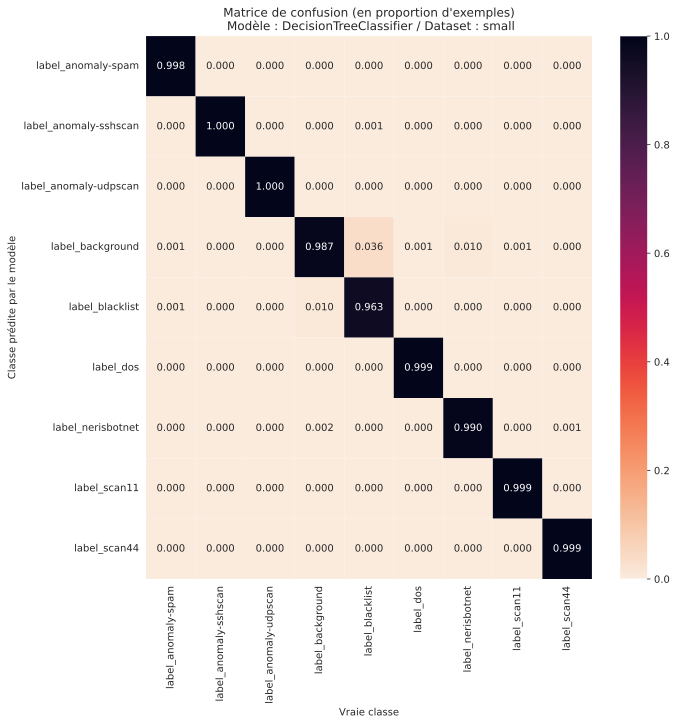

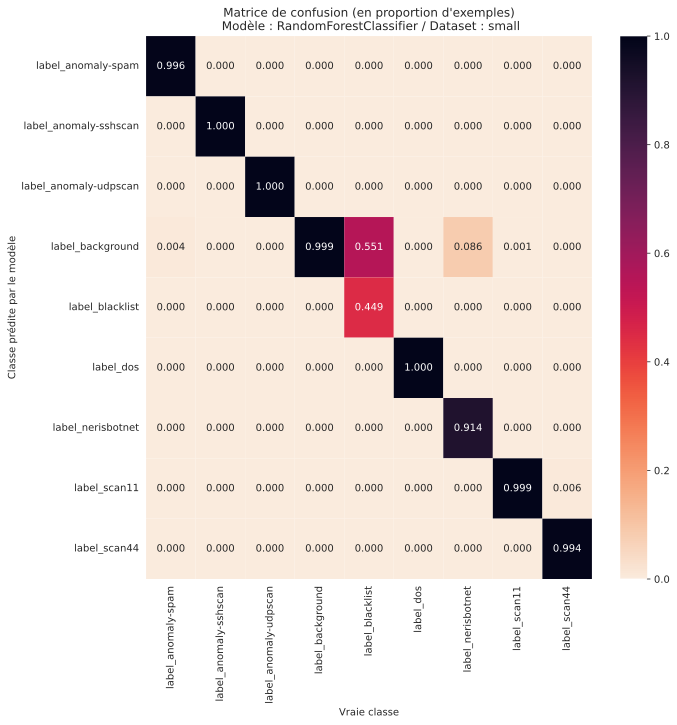

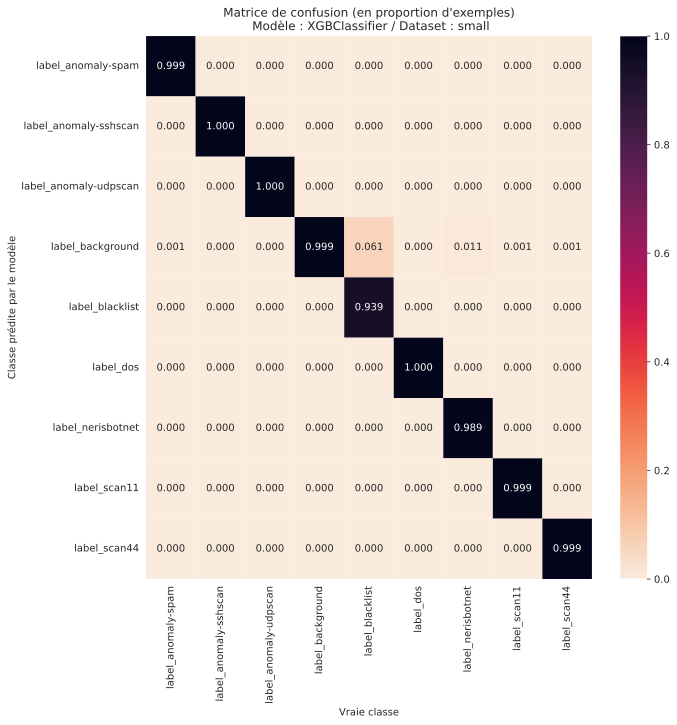

,accuracy_score,f1_score,roc_auc_score,precision_score,recall_score
model_name,,,,,
DecisionTreeClassifier,0.990417,0.990417,0.995670,0.990417,0.990417
RandomForestClassifier,0.959167,0.959167,0.959473,0.959167,0.959167
XGBClassifier,0.994931,0.994931,0.995219,0.994931,0.994931


In [203]:
performance_list = []
for model_name, model in model_dict.items():
    performance = evaluation(model_name, model, x_test, y_test)
    performance["model_name"] = model_name
    performance_list.append(performance)

pd.DataFrame(performance_list).set_index("model_name")

## Tester les modèles sur le jeu d'attaque avant l'attaque

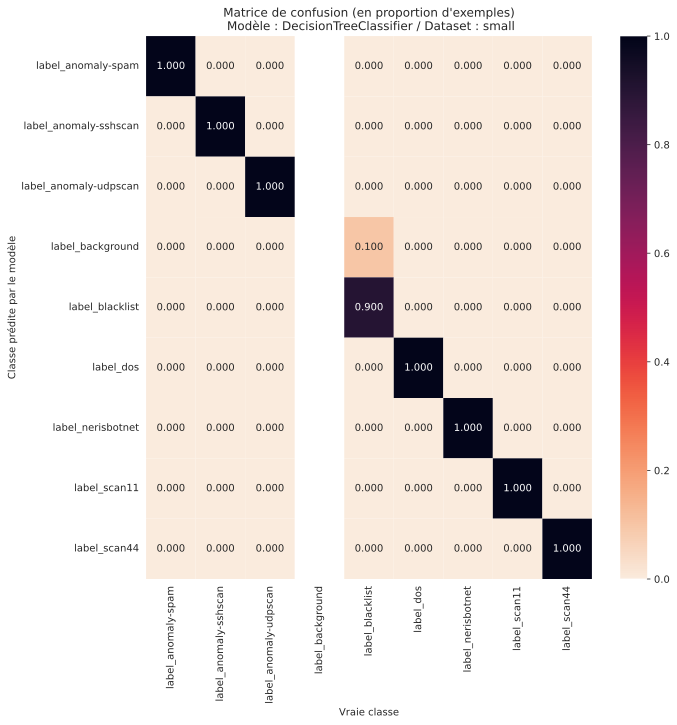

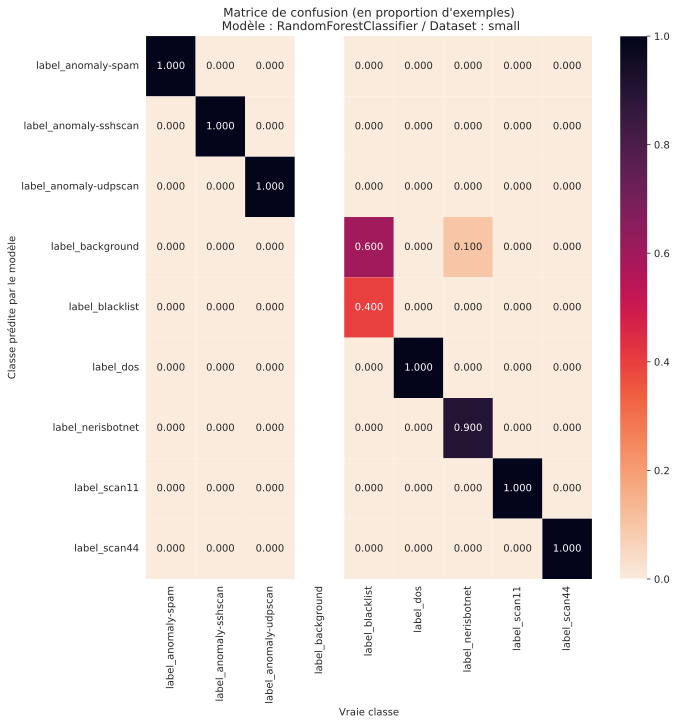

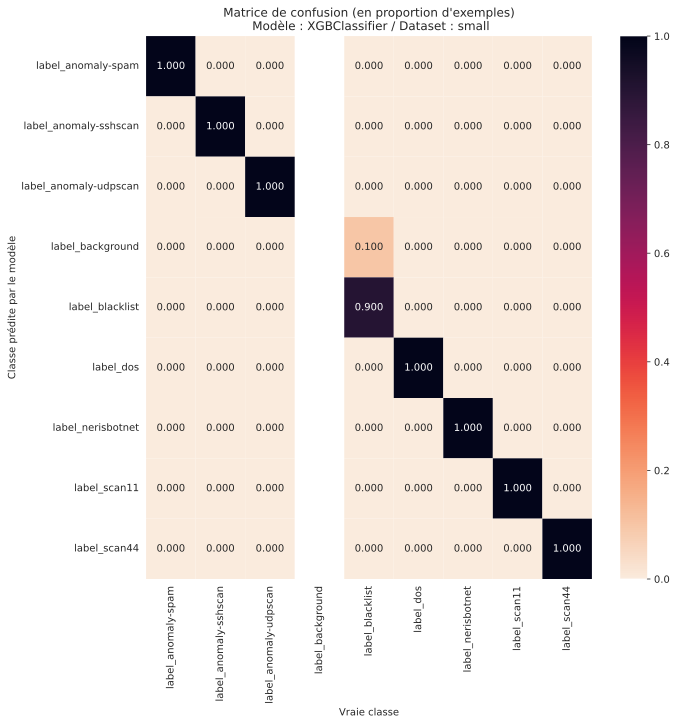

,accuracy_score,f1_score,precision_score,recall_score
model_name,,,,
DecisionTreeClassifier,0.9875,0.9875,0.9875,0.9875
RandomForestClassifier,0.9125,0.9125,0.9125,0.9125
XGBClassifier,0.9875,0.9875,0.9875,0.9875


In [204]:
performance_list = []
for model_name, model in model_dict.items():
    performance = evaluation(model_name, model, x_selected_attack, y_selected_attack, with_auroc=False)
    performance["model_name"] = model_name
    performance_list.append(performance)

pd.DataFrame(performance_list).set_index("model_name")

## Attaquer les modèles

Attaques ciblées : JSMA (SaliencyMapMethod), C&W (CarliniL2Method), ~~L-BFGS~~ (y'a pas), DecisionTreeAttack

In [205]:
from art.attacks.evasion import DecisionTreeAttack, ZooAttack, BoundaryAttack, HopSkipJump, TargetedUniversalPerturbation, UniversalPerturbation, VirtualAdversarialMethod
from art.estimators.classification import XGBoostClassifier
from art.estimators.classification.scikitlearn import ScikitlearnDecisionTreeClassifier, ScikitlearnRandomForestClassifier

### Single

In [206]:
classifier = ScikitlearnDecisionTreeClassifier(model=model_dict["DecisionTreeClassifier"])

In [207]:
background_label_id = LABEL_COLUMN_LIST.get_indexer(["label_background"])[0]
y_inject_target = np.array([background_label_id for _ in to_label_category(y_selected_attack)])

In [208]:
attack = DecisionTreeAttack(classifier=classifier)
x_adv = attack.generate(x=x_selected_attack.to_numpy(), y=y_inject_target)

Decision tree attack:   0%|          | 0/80 [00:00<?, ?it/s]

In [209]:
x_adv_df = pd.DataFrame(x_adv, index=x_selected_attack.index,columns=x_selected_attack.columns)

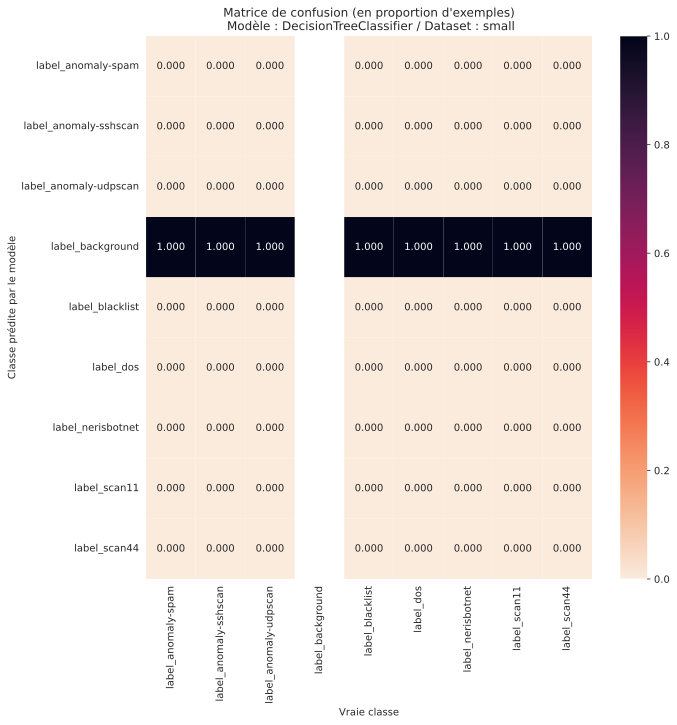

{'accuracy_score': 0.0,
 'f1_score': 0.0,
 'precision_score': 0.0,
 'recall_score': 0.0}

In [210]:
evaluation("DecisionTreeClassifier", model_dict["DecisionTreeClassifier"], x_adv_df, y_selected_attack, with_auroc=False)

In [212]:
describe.loc[:,describe.loc["mean"] != 0]

,source_port,destination_port,type,byte,flag_A,flag_S,source_ip_0,source_ip_1,source_ip_2,source_ip_3,destination_ip_0,destination_ip_2,destination_ip_3
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,0.058284,0.070659,0.021084,0.004066,0.043837,0.018788,0.021496,0.012135,0.053252,0.043744,0.003726,0.015590,0.102199
std,0.181277,0.202465,0.188580,0.030803,0.407979,0.095782,0.101524,0.032308,0.119895,0.083945,0.026176,0.047066,0.236058
min,-0.001053,0.000000,0.000000,0.000000,-0.501000,0.000000,0.000000,0.000000,0.000000,-0.010804,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-0.501000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001480,0.000000,0.000000,0.000000
75%,0.002072,0.004311,0.000000,0.001038,0.501000,0.000000,0.000000,0.000000,0.000000,0.077471,0.000000,0.000000,0.017667
max,0.873137,0.939323,1.686713,0.275914,0.501000,0.501000,0.526490,0.097078,0.601000,0.614725,0.222569,0.155902,0.826490


In [213]:
x_adv_df[["flag_A", "flag_S"]][x_adv_df[["flag_A", "flag_S"]] >= 0.5] = 1.0

/tmp/ipykernel_18885/3542219663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_adv_df[["flag_A", "flag_S"]][x_adv_df[["flag_A", "flag_S"]] >= 0.5] = 1.0
/tmp/ipykernel_18885/3542219663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_adv_df[["flag_A", "flag_S"]][x_adv_df[["flag_A", "flag_S"]] >= 0.5] = 1.0


In [214]:
x_adv_df.loc[:,["flag_A", "flag_S"]][x_adv_df[["flag_A", "flag_S"]] >= 0.5]

,flag_A,flag_S
120317,NaN,1.0
117751,NaN,NaN
99150,1.000,NaN
126807,0.501,1.0
101275,NaN,NaN
...,...,...
106454,NaN,NaN
137974,0.501,1.0
109018,1.000,1.0
122525,NaN,NaN


In [215]:
x_adv_df[["flag_A", "flag_S"]] = (x_adv_df[["flag_A", "flag_S"]] >= 0.5).astype(float)

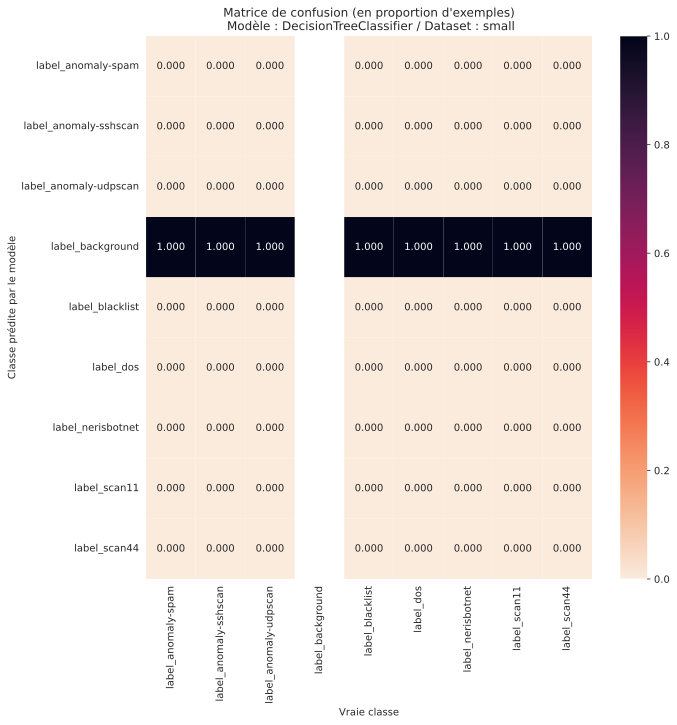

{'accuracy_score': 0.0,
 'f1_score': 0.0,
 'precision_score': 0.0,
 'recall_score': 0.0}

In [216]:
evaluation("DecisionTreeClassifier", model_dict["DecisionTreeClassifier"], x_adv_df, y_selected_attack, with_auroc=False)

In [217]:
mean_squared_error(x_selected_attack, x_adv_df)

0.03186724228379277

In [218]:
(x_selected_attack - x_adv_df)

,duration,source_port,destination_port,forwarding,type,packet,byte,protocol_ESP,protocol_GRE,protocol_ICMP,...,flag_F,day_progress,source_ip_0,source_ip_1,source_ip_2,source_ip_3,destination_ip_0,destination_ip_1,destination_ip_2,destination_ip_3
120317,0.0,0.016785,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
117751,0.0,0.001420,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
99150,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.52649,0.0,0.000000,-0.010804,0.000000,0.0,0.000000,0.000000
126807,0.0,0.000000,0.008660,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.089235,0.000000,0.0,0.000000,0.000000
101275,0.0,-0.001053,0.000000,0.0,0.0,0.0,0.001008,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.614725,0.222569,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106454,0.0,0.000000,0.002839,0.0,0.0,0.0,0.275914,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.079431,0.000000,0.000000,0.0,0.000000,0.618647
137974,0.0,0.000000,0.478577,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.073549,0.000000,0.0,0.000000,0.000000
109018,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.034333,0.000000,0.0,0.155902,0.000000
122525,0.0,0.804944,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


### Bench-mark

In [219]:
BATCH_SIZE = len(x_selected_attack)

In [220]:
background_label_id = LABEL_COLUMN_LIST.get_indexer(["label_background"])[0]
y_inject_target = np.array([background_label_id for _ in to_label_category(y_selected_attack)])

In [221]:
classifier_dict = dict()
classifier_dict["DecisionTreeClassifier"] = ScikitlearnDecisionTreeClassifier(model=model_dict["DecisionTreeClassifier"])
classifier_dict["RandomForestClassifier"] = ScikitlearnRandomForestClassifier(model=model_dict["RandomForestClassifier"])
classifier_dict["XGBClassifier"] = XGBoostClassifier(model=model_dict["XGBClassifier"], nb_features=x_selected_attack.shape[1])

In [222]:
def get_attack_list(model_name):
    attack_dict = dict()
    if model_name == "DecisionTreeClassifier":
        # Only DecisionTreeClassifier is compatible with DecisionTreeAttack
        attack_dict["DecisionTreeAttack"] = DecisionTreeAttack(classifier=classifier_dict[model_name])
    
    ##Float32#attack_dict["BoundaryAttack"] = BoundaryAttack(classifier_dict[model_name], targeted=True, batch_size=BATCH_SIZE, num_trial=1)
    attack_dict["HopSkipJump"] = HopSkipJump(classifier=classifier_dict[model_name], targeted=True, batch_size=BATCH_SIZE)
    ##Gradient#attack_dict["TargetedUniversalPerturbation"] = TargetedUniversalPerturbation(classifier=classifier_dict[model_name], attacker="deepfool")
    ##Gradient#attack_dict["UniversalPerturbation"] = UniversalPerturbation(classifier=classifier_dict[model_name], batch_size=BATCH_SIZE)
    ##Float32#attack_dict["VirtualAdversarialMethod"] = VirtualAdversarialMethod(classifier=classifier_dict[model_name], batch_size=BATCH_SIZE)

    # The current implementation of Zeroth-Order Optimisation attack only supports `batch_size=1` with feature vectors as input.
    attack_dict["ZooAttack"] = ZooAttack(classifier=classifier_dict[model_name], targeted=True, batch_size=1, nb_parallel=25, max_iter=50, learning_rate=0.001)
    return attack_dict

In [223]:
def fix_flag(data_df):
    flag_column_list = ['flag_U', 'flag_A', 'flag_P', 'flag_R', 'flag_S', 'flag_F']
    data_df[flag_column_list] = data_df[flag_column_list].clip(0,1)
    return data_df

def fix_protocol(data_df):
    protocol_column_list = data_df.columns[data_df.columns.str.startswith("protocol")]
    protocol_df = data_df[protocol_column_list]
    index_column_with_max = protocol_df.idxmax(axis=1)
    id_column_with_max = protocol_column_list.get_indexer(index_column_with_max)
    id_row_list = np.arange(len(protocol_df))
    result_array = np.zeros(protocol_df.shape)
    result_array[id_row_list, id_column_with_max] = 1
    data_df[protocol_column_list] = result_array
    return data_df

def fix_port(data_df):
    port_df = data_df[["source_port", "destination_port"]]
    unnorm_port_df = port_df*65_535
    unnorm_port_df = unnorm_port_df.astype(int)
    unnorm_port_df = unnorm_port_df.clip(0, 65_535)
    norm_port_df = unnorm_port_df/65_535
    data_df[["source_port", "destination_port"]] = norm_port_df
    return data_df

def fix_ip(data_df):
    ip_column_list = [ 'source_ip_0',
                       'source_ip_1',
                       'source_ip_2',
                       'source_ip_3',
                       'destination_ip_0',
                       'destination_ip_1',
                       'destination_ip_2',
                       'destination_ip_3']
    ip_df = data_df[ip_column_list]
    unnorm_ip_df = ip_df*255
    unnorm_ip_df = unnorm_ip_df.astype(int)
    unnorm_ip_df = unnorm_ip_df.clip(0, 255)
    norm_ip_df = unnorm_ip_df/255
    data_df[ip_column_list] = norm_ip_df
    return data_df

def fix_day_progress(data_df):
    data_df["day_progress"] = data_df["day_progress"].clip(0, 1)
    return data_df

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Decision tree attack:   0%|          | 0/80 [00:00<?, ?it/s]

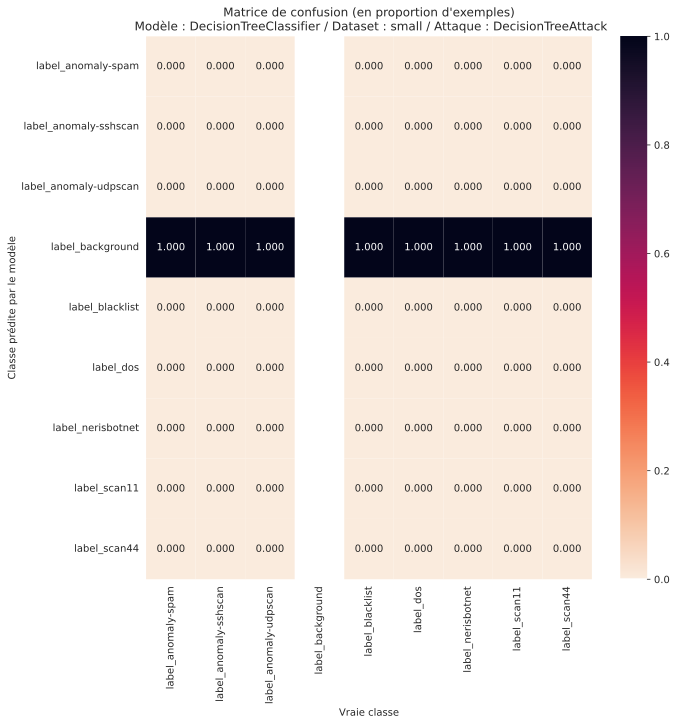

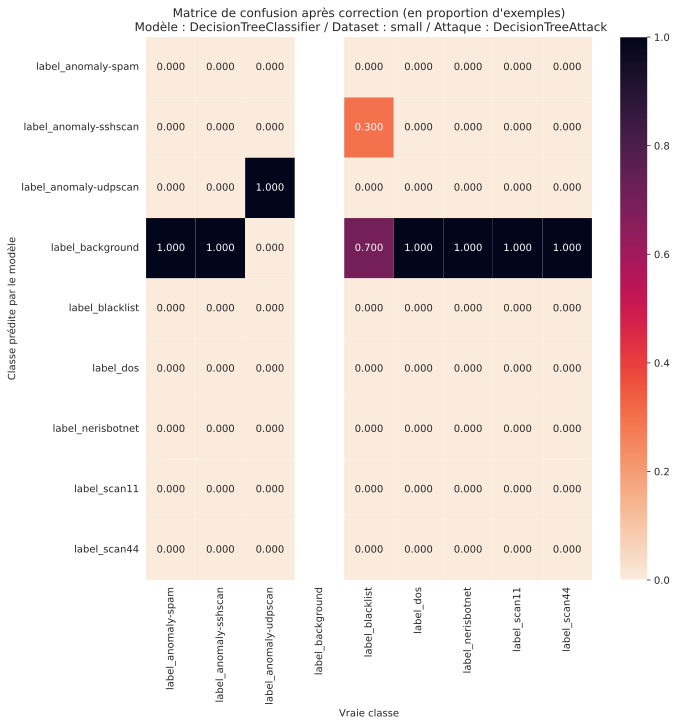

HopSkipJump:   0%|          | 0/80 [00:00<?, ?it/s]

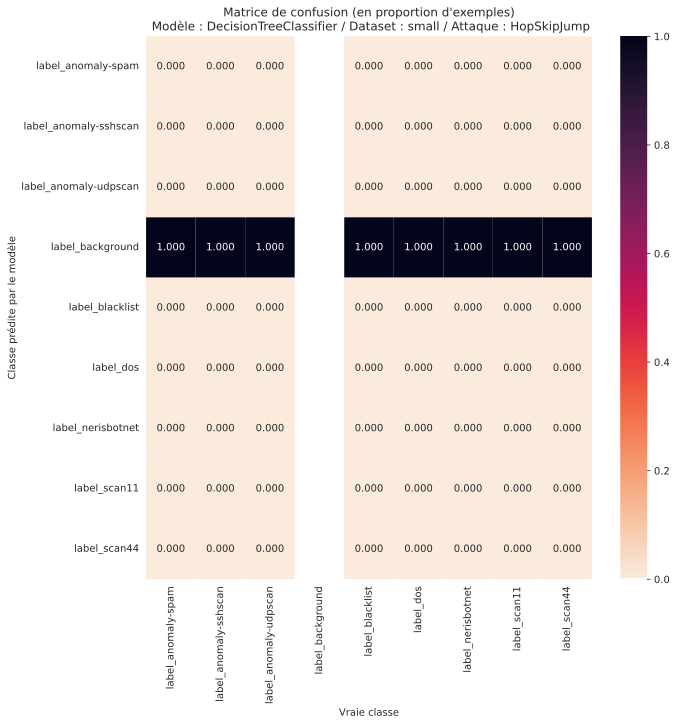

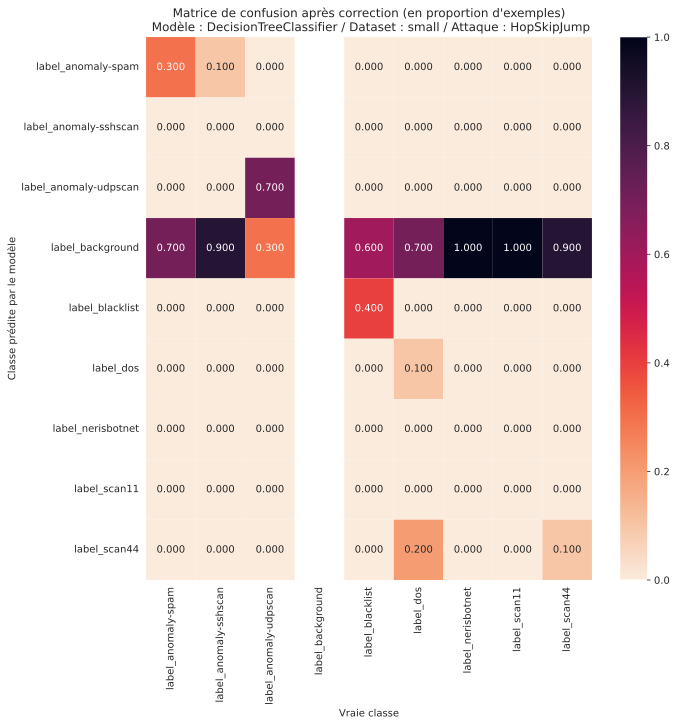

ZOO:   0%|          | 0/80 [00:00<?, ?it/s]

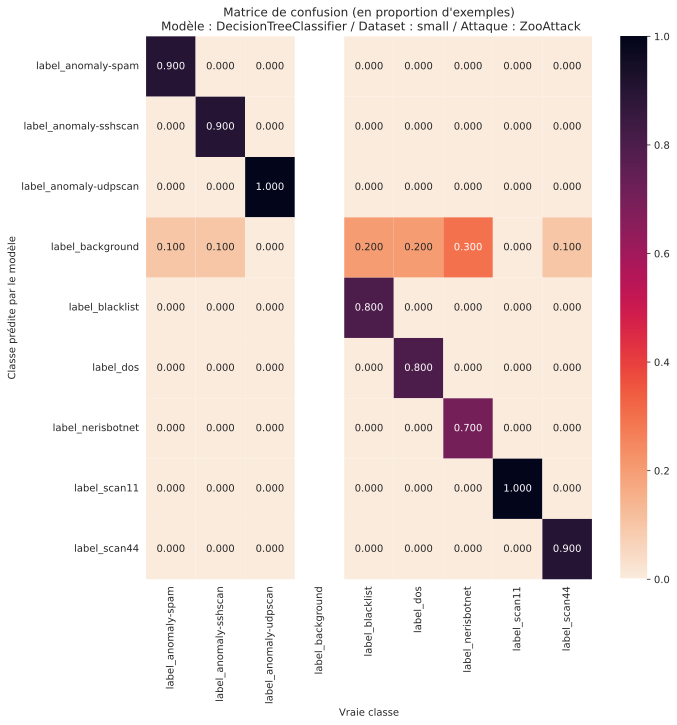

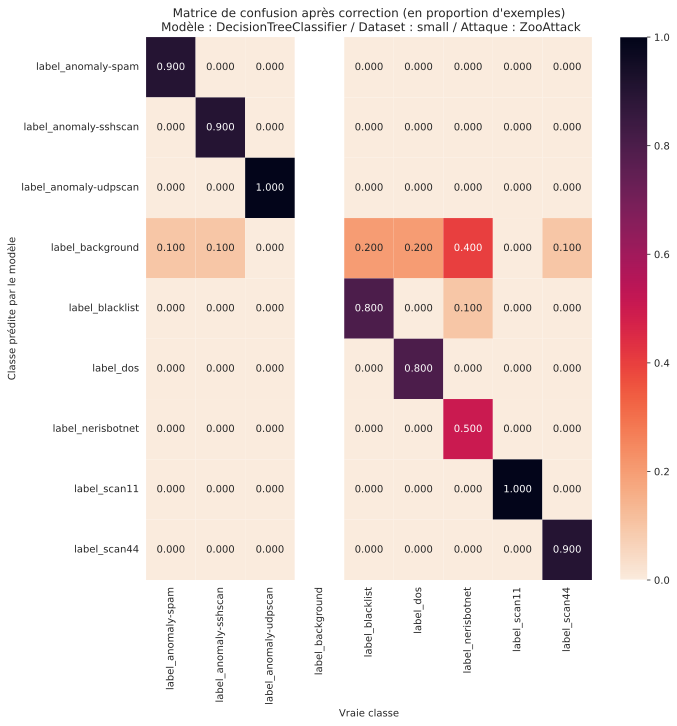

  0%|          | 0/2 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/80 [00:00<?, ?it/s]

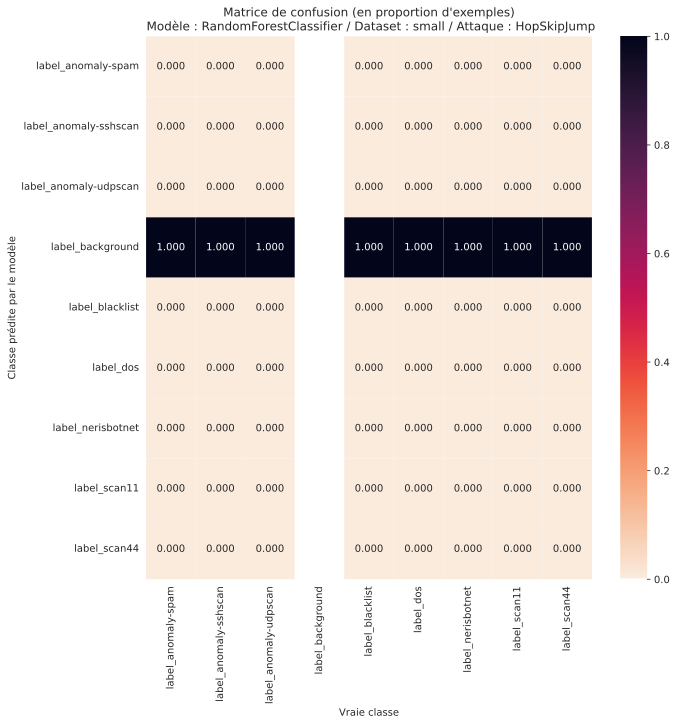

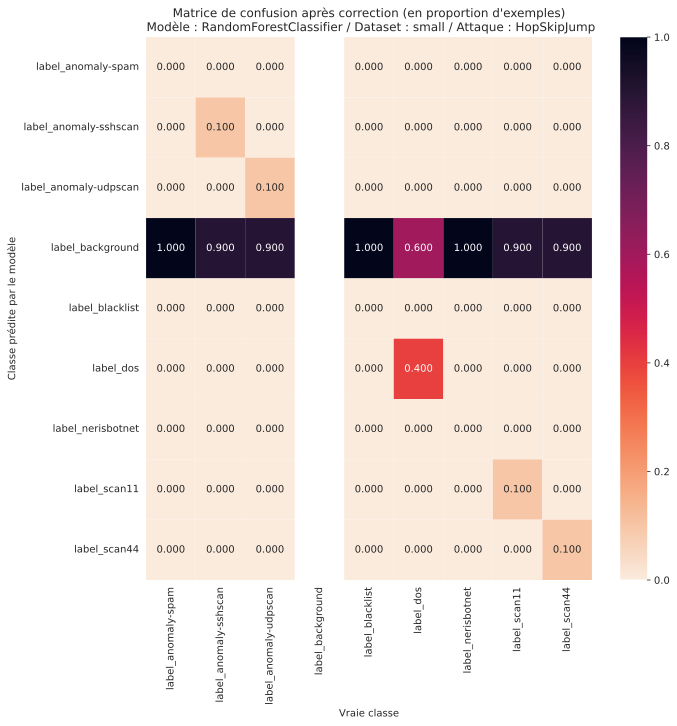

ZOO:   0%|          | 0/80 [00:00<?, ?it/s]

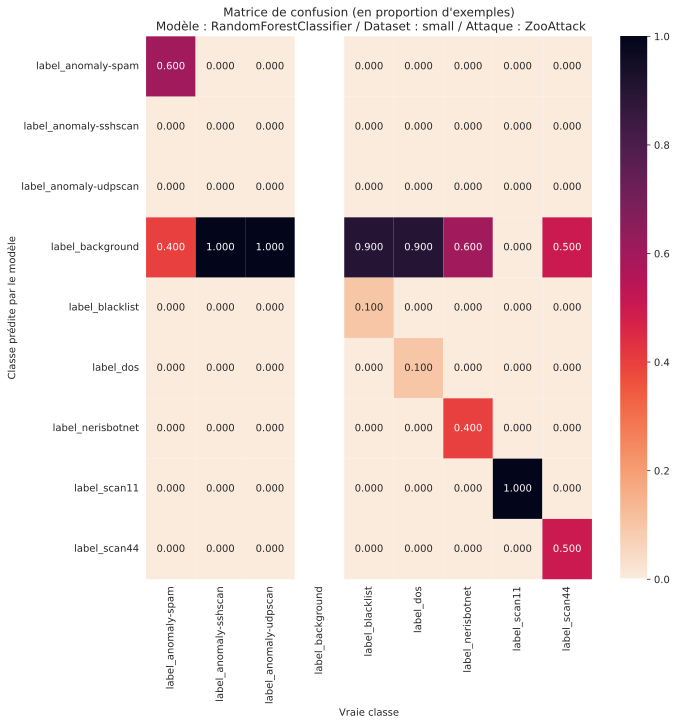

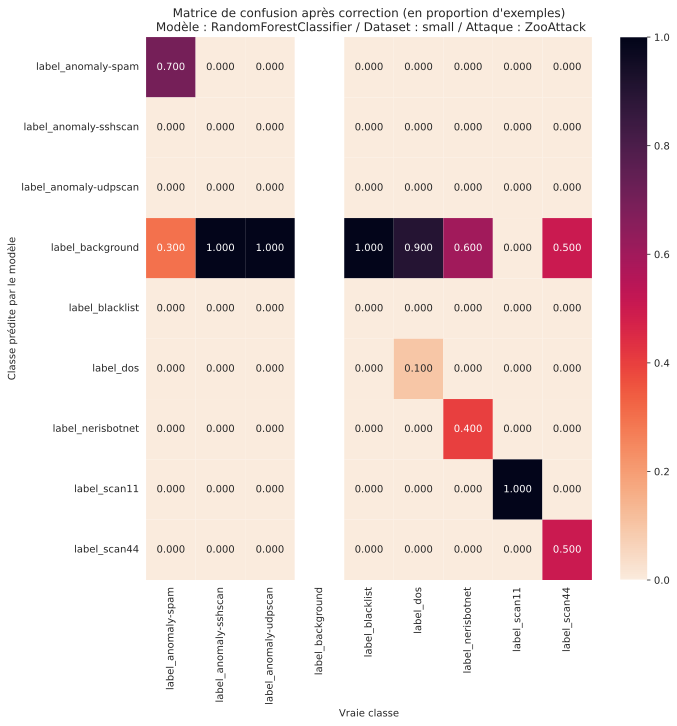

  0%|          | 0/2 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/80 [00:00<?, ?it/s]

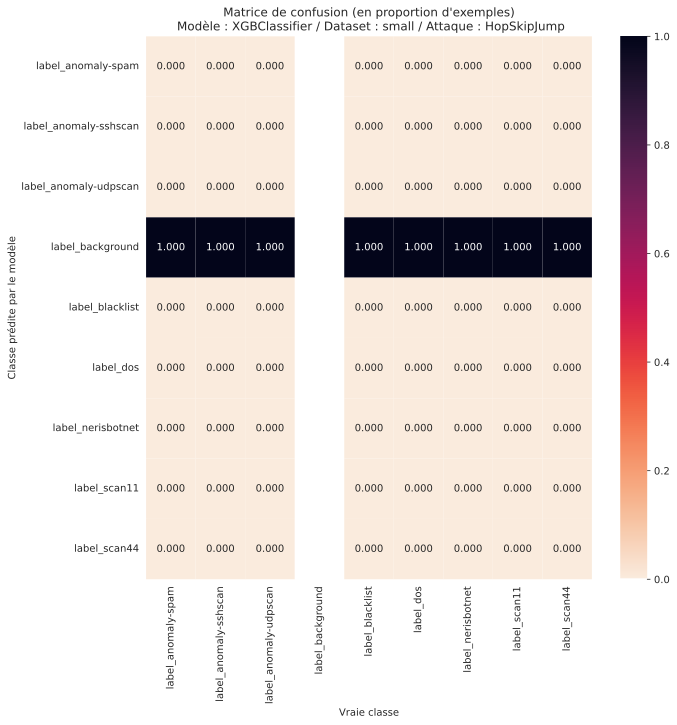

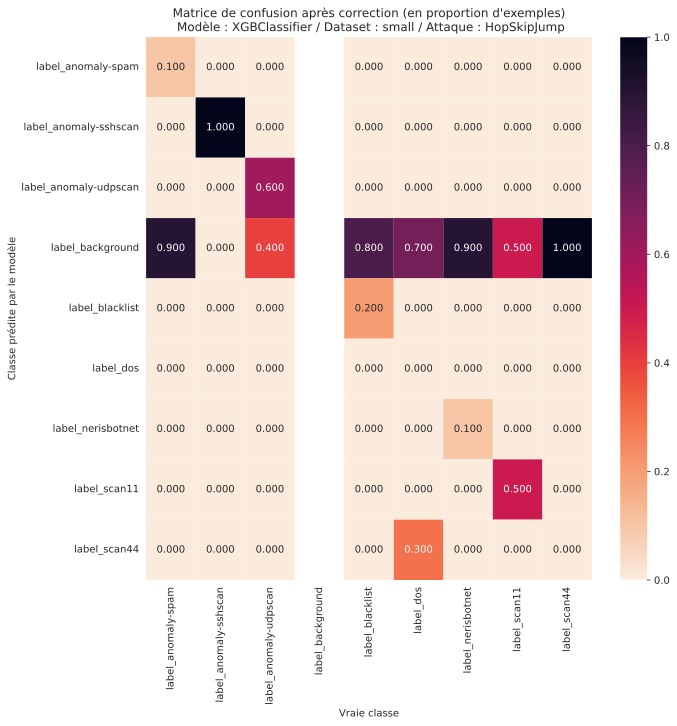

ZOO:   0%|          | 0/80 [00:00<?, ?it/s]

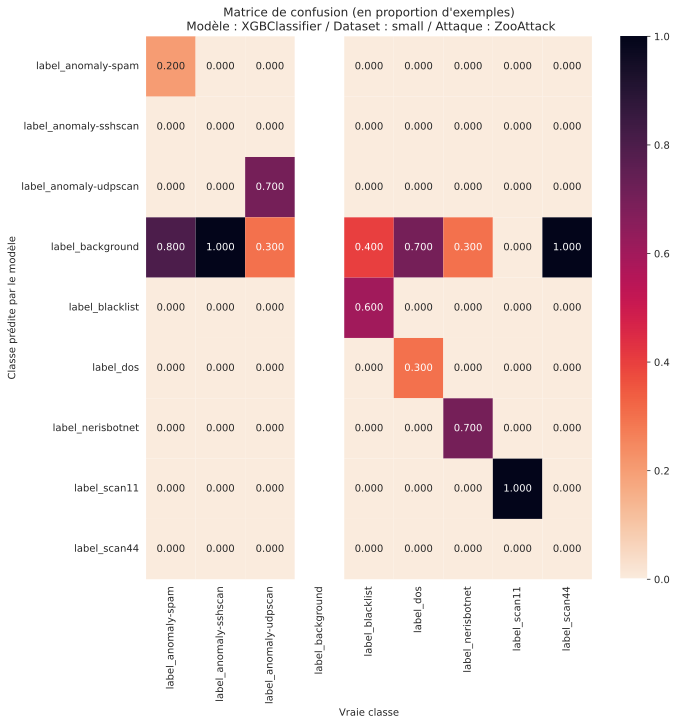

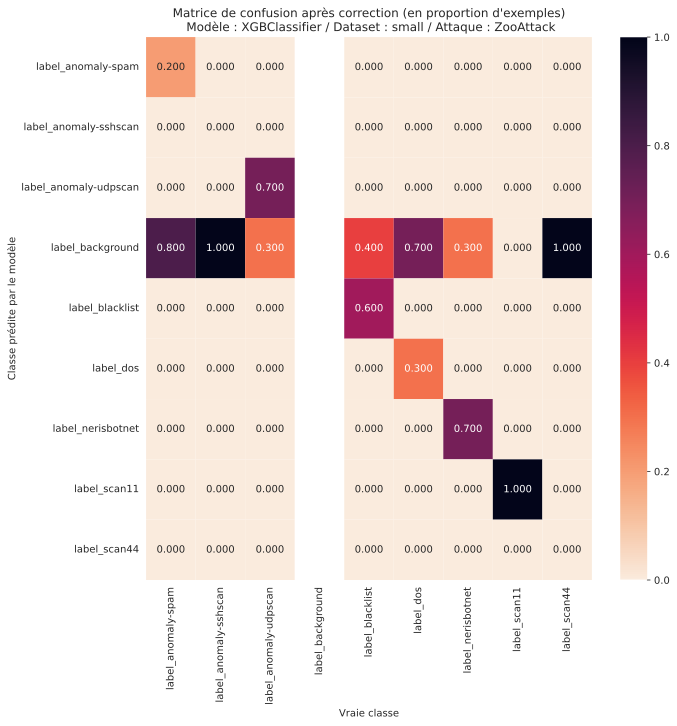

In [224]:
performance_before_fix_list = []
performance_after_fix_list = []
model_progress = tqdm(classifier_dict.items())
for model_name, model in model_progress:
    model_progress.set_description(model_name)
    attack_progress = tqdm(get_attack_list(model_name).items(), leave=False)
    for attack_name, attack in attack_progress:
        attack_progress.set_description(attack_name)

        start_attack_time = time.time()
        x_adv = attack.generate(x=x_selected_attack.to_numpy(), y=y_inject_target)
        attack_duration = time.time() - start_attack_time

        # Perf before fix
        x_adv_df = pd.DataFrame(x_adv, index=x_selected_attack.index,columns=x_selected_attack.columns)
        performance_before_fix = evaluation(model_name, model_dict[model_name], x_adv_df, y_selected_attack, 
                                with_auroc=False, 
                                attack_name=attack_name, 
                                fig_path=f"{model_name}_{LEVEL}_{attack_name}")
        
        
        performance_before_fix["model_name"] = model_name
        performance_before_fix["attack_name"] = attack_name
        performance_before_fix["attack_duration"] = attack_duration
        performance_before_fix["eps"] = mean_squared_error(x_selected_attack, x_adv_df)

        performance_before_fix_list.append(performance_before_fix)

        # Perf after fix
        fixed_x_adv_df = x_adv_df.copy()
        ## Fix
        fix_flag(fixed_x_adv_df)
        fix_protocol(fixed_x_adv_df)
        fix_port(fixed_x_adv_df)
        fix_ip(fixed_x_adv_df)
        fix_day_progress(fixed_x_adv_df)

        performance_after_fix = evaluation(model_name, model_dict[model_name], fixed_x_adv_df, y_selected_attack, 
                        with_auroc=False, 
                        attack_name=attack_name, 
                        fig_path=f"{model_name}_{LEVEL}_{attack_name}_FIXED", title_suffix="après correction ")

        performance_after_fix["model_name"] = model_name
        performance_after_fix["attack_name"] = attack_name
        performance_after_fix["attack_duration"] = attack_duration
        performance_after_fix["eps"] = mean_squared_error(x_selected_attack, fixed_x_adv_df)

        performance_after_fix_list.append(performance_after_fix)

pd.DataFrame(performance_before_fix_list).to_csv("performance_after_attack_before_fix.csv")
pd.DataFrame(performance_after_fix_list).to_csv("performance_after_attack_after_fix.csv")
        

In [225]:
pd.DataFrame(performance_before_fix_list)

,accuracy_score,f1_score,precision_score,recall_score,model_name,attack_name,attack_duration,eps
0,0.0000,0.0000,0.0000,0.0000,DecisionTreeClassifier,DecisionTreeAttack,0.112157,1.378796e-02
1,0.0000,0.0000,0.0000,0.0000,DecisionTreeClassifier,HopSkipJump,13.679242,6.456406e-07
2,0.8750,0.8750,0.8750,0.8750,DecisionTreeClassifier,ZooAttack,0.760787,3.800097e-10
3,0.0000,0.0000,0.0000,0.0000,RandomForestClassifier,HopSkipJump,519.927516,1.690868e-07
4,0.3375,0.3375,0.3375,0.3375,RandomForestClassifier,ZooAttack,20.665994,8.839197e-08
5,0.0000,0.0000,0.0000,0.0000,XGBClassifier,HopSkipJump,176.008633,1.181686e-07
6,0.4375,0.4375,0.4375,0.4375,XGBClassifier,ZooAttack,11.975241,1.367615e-08


In [226]:
perf_bf = pd.DataFrame(performance_before_fix_list)
perf_af = pd.DataFrame(performance_after_fix_list)

In [232]:
perf_bf = perf_bf.sort_values(["accuracy_score", "eps", "attack_duration"], ascending=[True, True, True]).set_index(["model_name", "attack_name"])
perf_bf

accuracy_score  f1_score  \
model_name             attack_name                                    
XGBClassifier          HopSkipJump                 0.0000    0.0000   
RandomForestClassifier HopSkipJump                 0.0000    0.0000   
DecisionTreeClassifier HopSkipJump                 0.0000    0.0000   
                       DecisionTreeAttack          0.0000    0.0000   
RandomForestClassifier ZooAttack                   0.3375    0.3375   
XGBClassifier          ZooAttack                   0.4375    0.4375   
DecisionTreeClassifier ZooAttack                   0.8750    0.8750   

                                           precision_score  recall_score  \
model_name             attack_name                                         
XGBClassifier          HopSkipJump                  0.0000        0.0000   
RandomForestClassifier HopSkipJump                  0.0000        0.0000   
DecisionTreeClassifier HopSkipJump                  0.0000        0.0000   
                       DecisionTreeAttack           0.0000        0.0000   
RandomForestClassifier ZooAttack                    0.3375        0.3375   
XGBClassifier          ZooAttack                    0.4375        0.4375   
DecisionTreeClassifier ZooAttack                    0.8750        0.8750   

                                           attack_duration           eps  
model_name             attack_name                                        
XGBClassifier          HopSkipJump              176.008633  1.181686e-07  
RandomForestClassifier HopSkipJump              519.927516  1.690868e-07  
DecisionTreeClassifier HopSkipJump               13.679242  6.456406e-07  
                       DecisionTreeAttack         0.112157  1.378796e-02  
RandomForestClassifier ZooAttack                 20.665994  8.839197e-08  
XGBClassifier          ZooAttack                 11.975241  1.367615e-08  
DecisionTreeClassifier ZooAttack                  0.760787  3.800097e-10

In [233]:
perf_af = perf_af.sort_values(["accuracy_score", "eps", "attack_duration"], ascending=[True, True, True]).set_index(["model_name", "attack_name"])
perf_af

accuracy_score  f1_score  \
model_name             attack_name                                    
RandomForestClassifier HopSkipJump                 0.1000    0.1000   
DecisionTreeClassifier DecisionTreeAttack          0.1250    0.1250   
                       HopSkipJump                 0.2000    0.2000   
XGBClassifier          HopSkipJump                 0.3125    0.3125   
RandomForestClassifier ZooAttack                   0.3375    0.3375   
XGBClassifier          ZooAttack                   0.4375    0.4375   
DecisionTreeClassifier ZooAttack                   0.8500    0.8500   

                                           precision_score  recall_score  \
model_name             attack_name                                         
RandomForestClassifier HopSkipJump                  0.1000        0.1000   
DecisionTreeClassifier DecisionTreeAttack           0.1250        0.1250   
                       HopSkipJump                  0.2000        0.2000   
XGBClassifier          HopSkipJump                  0.3125        0.3125   
RandomForestClassifier ZooAttack                    0.3375        0.3375   
XGBClassifier          ZooAttack                    0.4375        0.4375   
DecisionTreeClassifier ZooAttack                    0.8500        0.8500   

                                           attack_duration       eps  
model_name             attack_name                                    
RandomForestClassifier HopSkipJump              519.927516  0.000002  
DecisionTreeClassifier DecisionTreeAttack         0.112157  0.013812  
                       HopSkipJump               13.679242  0.000003  
XGBClassifier          HopSkipJump              176.008633  0.000002  
RandomForestClassifier ZooAttack                 20.665994  0.000002  
XGBClassifier          ZooAttack                 11.975241  0.000002  
DecisionTreeClassifier ZooAttack                  0.760787  0.000001

In [234]:
perf_bf.to_csv("performance_after_attack_before_fix_encoded.csv", float_format='%.3f')
perf_af.to_csv("performance_after_attack_after_fix_encoded.csv", float_format='%.3f')

In [146]:
x_adv_df

,duration,source_port,destination_port,forwarding,type,packet,byte,protocol_ESP,protocol_GRE,protocol_ICMP,...,flag_F,day_progress,source_ip_0,source_ip_1,source_ip_2,source_ip_3,destination_ip_0,destination_ip_1,destination_ip_2,destination_ip_3
8154,-0.096248,0.620737,0.000381,0.0,-0.458772,-0.011414,-0.016044,0.0,0.0,0.0,...,0.0,0.739387,0.164706,0.858824,0.611765,0.843137,0.992157,0.533333,0.631373,0.788235
114372,-0.121500,0.001551,0.297276,0.0,-0.458772,-0.019127,-0.016606,0.0,0.0,0.0,...,0.0,0.553102,0.164706,0.858824,0.596078,0.078431,0.164706,0.858824,0.588235,0.952941
119558,-0.112885,0.072511,0.001221,0.0,-0.458772,-0.005243,-0.014980,0.0,0.0,0.0,...,1.0,0.819039,0.164706,0.858824,0.603922,0.270588,0.121569,0.752941,0.427451,0.654902
109436,-0.118988,0.075776,0.001221,0.0,-0.458772,-0.014499,-0.016127,0.0,0.0,0.0,...,0.0,0.464606,0.164706,0.858824,0.588235,0.952941,0.164706,0.858824,0.596078,0.078431
105975,-0.120104,0.001221,0.349050,0.0,-0.365121,0.010184,0.049330,0.0,0.0,0.0,...,0.0,0.108958,0.164706,0.858824,0.619608,0.737255,0.356863,0.278431,0.494118,0.701961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101083,-0.088853,0.006760,0.776761,0.0,-0.458772,0.004013,0.017043,0.0,0.0,0.0,...,1.0,0.630359,0.164706,0.858824,0.619608,0.737255,0.164706,0.623529,0.364706,0.682353
13005,-0.016620,0.866026,0.000666,0.0,-0.458772,-0.005243,-0.014443,0.0,0.0,0.0,...,1.0,0.605868,0.164706,0.858824,0.611765,0.905882,0.278431,0.098039,0.792157,0.133333
143337,-0.121500,0.928847,0.091356,0.0,-0.458772,-0.019127,-0.016597,0.0,0.0,0.0,...,0.0,0.235532,0.164706,0.858824,0.588235,0.952941,0.164706,0.858824,0.596078,0.078431
4389,-0.112292,0.000712,0.817365,0.0,2.912653,-0.016042,-0.016839,0.0,0.0,0.0,...,1.0,0.727049,0.752941,0.560784,0.341176,0.470588,0.164706,0.858824,0.611765,0.839216


*65_535 int => /65_535
'source_port',
 'destination_port',

*255 int /255
 'source_ip_0',
 'source_ip_1',
 'source_ip_2',
 'source_ip_3',
 'destination_ip_0',
 'destination_ip_1',
 'destination_ip_2',
 'destination_ip_3']

max 1, min 0
 'day_progress', 

int, max 1, min 0
 'flag_U',
 'flag_A',
 'flag_P',
 'flag_R',
 'flag_S',
 'flag_F',

1 seul 1, reste à 0
'protocol_ESP',
'protocol_GRE',
'protocol_ICMP',
'protocol_IPIP',
'protocol_IPv6',
'protocol_TCP',
'protocol_UDP',

##### Tests

In [235]:
attack = get_attack_list("DecisionTreeClassifier")["DecisionTreeAttack"]
x_adv = attack.generate(x=x_selected_attack.to_numpy(), y=y_inject_target)

Decision tree attack:   0%|          | 0/80 [00:00<?, ?it/s]

In [236]:
x_adv_df = pd.DataFrame(x_adv, index=x_selected_attack.index,columns=x_selected_attack.columns)

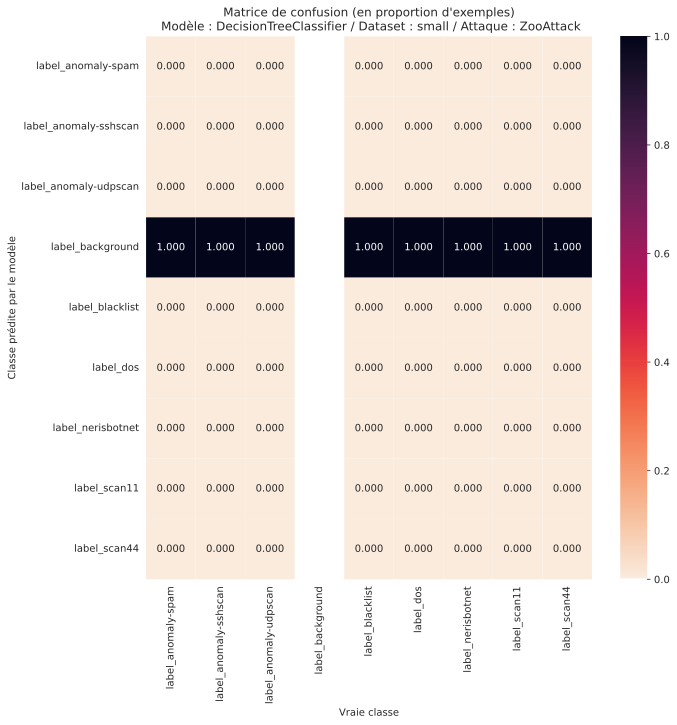

{'accuracy_score': 0.0,
 'f1_score': 0.0,
 'precision_score': 0.0,
 'recall_score': 0.0}

In [237]:
evaluation("DecisionTreeClassifier", model_dict["DecisionTreeClassifier"], x_adv_df, y_selected_attack, with_auroc=False, attack_name="ZooAttack")

In [238]:
mean_squared_error(x_selected_attack, x_adv_df)

0.013787956076896224

In [240]:
fixed_x_adv_df = x_adv_df.copy()

In [241]:
fix_flag(fixed_x_adv_df)
fix_protocol(fixed_x_adv_df)
fix_port(fixed_x_adv_df)
fix_ip(fixed_x_adv_df)
fix_day_progress(fixed_x_adv_df)

,duration,source_port,destination_port,forwarding,type,packet,byte,protocol_ESP,protocol_GRE,protocol_ICMP,...,flag_F,day_progress,source_ip_0,source_ip_1,source_ip_2,source_ip_3,destination_ip_0,destination_ip_1,destination_ip_2,destination_ip_3
120317,0.192824,0.000000,0.000366,0.0,-0.458772,-0.011414,-0.016379,0.0,0.0,0.0,...,0.0,0.497963,0.160784,0.858824,0.596078,0.082353,0.290196,0.486275,0.149020,0.101961
117751,-0.114315,0.000000,0.031678,0.0,-0.458772,-0.019127,-0.016642,0.0,0.0,0.0,...,0.0,0.499225,0.333333,0.062745,0.894118,0.184314,0.160784,0.858824,0.611765,0.109804
99150,-0.121500,0.001205,0.936721,0.0,-0.458772,-0.019127,-0.016927,0.0,0.0,0.0,...,0.0,0.290081,0.211765,0.321569,0.298039,0.043137,0.160784,0.858824,0.615686,0.403922
126807,-0.121360,0.794522,0.000000,0.0,-0.458772,-0.017585,-0.016838,0.0,0.0,0.0,...,0.0,0.465405,0.160784,0.858824,0.588235,0.874510,0.160784,0.858824,0.603922,0.266667
101275,-0.121500,0.001389,0.613245,0.0,-0.458772,-0.019127,-0.017845,0.0,0.0,0.0,...,0.0,0.623275,0.160784,0.858824,0.619608,0.121569,0.298039,0.066667,0.741176,0.486275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106454,0.050520,0.665797,0.000000,0.0,1.414242,0.119715,-0.017668,0.0,0.0,0.0,...,0.0,0.806262,0.254902,0.145098,0.396078,0.886275,0.160784,0.858824,0.619608,0.117647
137974,-0.121500,0.902449,0.000000,0.0,-0.458772,-0.019127,-0.016927,0.0,0.0,0.0,...,0.0,0.653727,0.160784,0.858824,0.588235,0.874510,0.160784,0.858824,0.603922,0.266667
109018,-0.121500,0.001205,0.201221,0.0,-0.458772,-0.019127,-0.016936,0.0,0.0,0.0,...,0.0,0.758044,0.160784,0.858824,0.596078,0.043137,0.160784,0.858824,0.431373,0.952941
122525,-0.121500,0.000000,0.000793,0.0,-0.458772,-0.019127,-0.016869,0.0,0.0,0.0,...,0.0,0.826389,0.160784,0.858824,0.611765,0.105882,0.560784,0.282353,0.027451,0.537255


In [242]:
mean_squared_error(x_selected_attack, fixed_x_adv_df)

0.01381180575766721

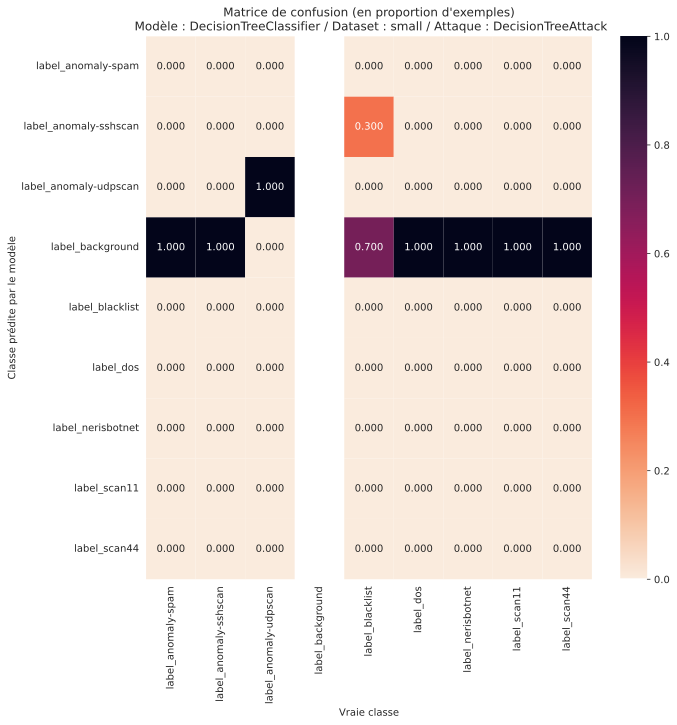

{'accuracy_score': 0.125,
 'f1_score': 0.125,
 'precision_score': 0.125,
 'recall_score': 0.125}

In [243]:
evaluation("DecisionTreeClassifier", model_dict["DecisionTreeClassifier"], fixed_x_adv_df, y_selected_attack, with_auroc=False, attack_name="DecisionTreeAttack")

In [244]:
describe = (fixed_x_adv_df - x_selected_attack).describe()

In [245]:
describe.loc[:,describe.loc["mean"] != 0]

,source_port,destination_port,type,byte,flag_A,flag_S,source_ip_0,source_ip_1,source_ip_2,source_ip_3,destination_ip_0,destination_ip_1,destination_ip_2,destination_ip_3
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,-0.058129,-0.070477,-0.021084,-0.004066,-0.043837,-0.018788,-0.024510,-0.012549,-0.054412,-0.045490,-0.006520,-0.000637,-0.016225,-0.104167
std,0.181140,0.202367,0.188580,0.030803,0.407979,0.095782,0.101483,0.032533,0.120696,0.083522,0.026042,0.001456,0.047194,0.235640
min,-0.872526,-0.938918,-1.686713,-0.275914,-0.501000,-0.501000,-0.529412,-0.098039,-0.603922,-0.615686,-0.223529,-0.003922,-0.156863,-0.827451
25%,-0.001461,-0.003906,0.000000,-0.001038,-0.501000,0.000000,-0.003922,0.000000,-0.003922,-0.078431,-0.003922,0.000000,0.000000,-0.018627
50%,-0.000015,-0.000015,0.000000,0.000000,0.000000,0.000000,-0.003922,0.000000,0.000000,-0.003922,-0.003922,0.000000,0.000000,-0.003922
75%,0.000000,-0.000015,0.000000,0.000000,0.501000,0.000000,-0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.001053,0.000000,0.000000,0.000000,0.501000,0.000000,0.000000,0.000000,0.000000,0.007843,0.000000,0.000000,0.000000,0.000000


In [246]:
describe.loc[:,describe.loc["mean"] != 0].columns

Index(['source_port', 'destination_port', 'type', 'byte', 'flag_A', 'flag_S',
       'source_ip_0', 'source_ip_1', 'source_ip_2', 'source_ip_3',
       'destination_ip_0', 'destination_ip_1', 'destination_ip_2',
       'destination_ip_3'],
      dtype='object')